# Traffic Sign Recognition: A Comprehensive Guide Using Deep Learning

# Introduction

In this project, we tackle the problem of traffic sign recognition using deep learning techniques. Traffic sign recognition is a critical component of autonomous driving systems and advanced driver-assistance systems (ADAS). The goal is to classify images of traffic signs into their respective categories accurately.

## Dataset Overview

We use the German Traffic Sign Recognition Benchmark (GTSRB) dataset from Kaggle. This dataset contains over 50,000 images of traffic signs belonging to 43 different classes. The images are in color, vary in size, and include real-world variations such as lighting changes, occlusions, and weather conditions.

* Classes: 43 (e.g., speed limits, stop signs, yield signs, etc.)
* Training Images: Approximately 39,209
* Test Images: Approximately 12,630
* Image Format: RGB, varying resolutions (typically 30x30 to 250x250 pixels)

## Objectives

* Preprocess the images (resizing, normalization).
* Build and train a custom Convolutional Neural Network (CNN) for multi-class classification.
* Evaluate the model using accuracy and confusion matrix.
* Implement data augmentation to improve performance.
* Compare the custom CNN with a pre-trained model (e.g., MobileNet).

## Tools and Libraries

* Python: Core programming language.
* Keras & TensorFlow: For building and training the CNN.
* OpenCV: For image processing and loading.
* Additional: NumPy, Pandas, Matplotlib, Scikit-learn for data handling, visualization, and evaluation.

# Importing Libraries
We start by importing the necessary libraries.

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import os
import cv2

# Loading the Dataset
Assuming the GTSRB dataset is downloaded and extracted in the working directory. The dataset includes:

* Train/ folder with subfolders for each class (0-42).
* Test/ folder with test images.
* CSV files: Train.csv and Test.csv for labels and metadata.

We load the metadata and prepare the image paths.

Number of training samples: 39209
Number of test samples: 12630
Number of classes: 43
Columns in Meta.csv: ['Path', 'ClassId', 'ShapeId', 'ColorId', 'SignId']
Using hardcoded class names for GTSRB dataset.


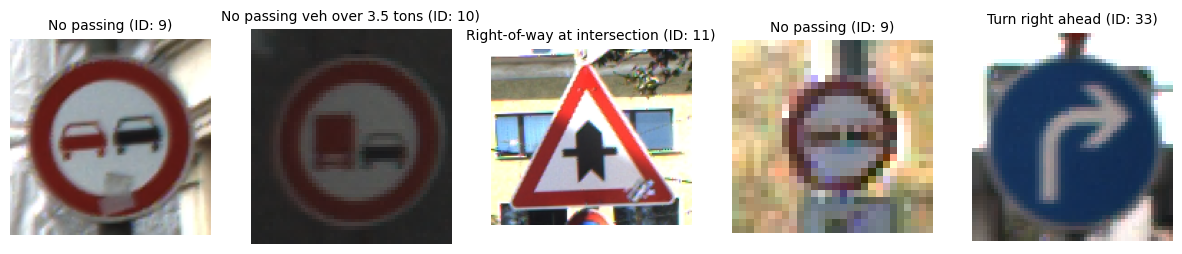

In [7]:
# Define paths
base_path = '/kaggle/input/gtsrb-german-traffic-sign'
train_csv = pd.read_csv(os.path.join(base_path, 'Train.csv'))
test_csv = pd.read_csv(os.path.join(base_path, 'Test.csv'))
meta_csv = pd.read_csv(os.path.join(base_path, 'Meta.csv'))  # Load Meta.csv for reference

# Display dataset info
print(f"Number of training samples: {len(train_csv)}")
print(f"Number of test samples: {len(test_csv)}")
print(f"Number of classes: {train_csv['ClassId'].nunique()}")
print("Columns in Meta.csv:", meta_csv.columns.tolist())

# Hardcode class names since 'SignName' is not in Meta.csv
class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}
print("Using hardcoded class names for GTSRB dataset.")

# Sample visualization
def plot_sample_images(df, class_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, (idx, row) in enumerate(df.sample(num_samples).iterrows()):
        img_path = os.path.join(base_path, row['Path'])
        img = cv2.imread(img_path)
        if img is not None:  # Ensure image is loaded
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
            axes[i].set_title(f"{class_names[row['ClassId']]} (ID: {row['ClassId']})", fontsize=10)
            axes[i].axis('off')
    plt.show()

plot_sample_images(train_csv, class_names)

# Data Preprocessing
Resize images to a fixed size, normalize, and prepare data generators.

In [8]:
# Image parameters
IMG_SIZE = 32  # For custom CNN; will change for MobileNet
BATCH_SIZE = 64
NUM_CLASSES = 43
EPOCHS = 20

# For custom CNN
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


# Build Custom CNN Model

In [9]:
custom_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

custom_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
custom_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756220757.178070      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756220757.178821      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [10]:
history_custom = custom_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756220786.480046     146 service.cc:148] XLA service 0x79306c026a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756220786.481664     146 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756220786.481684     146 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756220786.926811     146 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/491 ━━━━━━━━━━━━━━━━━━━━ 54:10 7s/step - accuracy: 0.0000e+00 - loss: 3.7954

I0000 00:00:1756220790.408279     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 ━━━━━━━━━━━━━━━━━━━━ 192s 378ms/step - accuracy: 0.2554 - loss: 2.7800 - val_accuracy: 0.7625 - val_loss: 0.8352
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 38s 77ms/step - accuracy: 0.7970 - loss: 0.6636 - val_accuracy: 0.8795 - val_loss: 0.4437
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.8959 - loss: 0.3360 - val_accuracy: 0.9083 - val_loss: 0.3315
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.9324 - loss: 0.2197 - val_accuracy: 0.9235 - val_loss: 0.2955
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 38s 77ms/step - accuracy: 0.9485 - loss: 0.1669 - val_accuracy: 0.9268 - val_loss: 0.2947
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.9652 - loss: 0.1158 - val_accuracy: 0.9429 - val_loss: 0.2480
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.9684 - loss: 0.1013 - val_accuracy: 0.9434 - val_loss: 0.2569
Epoch 8/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.9759 - loss: 0.0790 - val_accur

# Evaluate Custom CNN

Found 12630 validated image filenames belonging to 43 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 69s 347ms/step - accuracy: 0.9584 - loss: 0.2314
Custom CNN Test Accuracy: 0.9572
198/198 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step


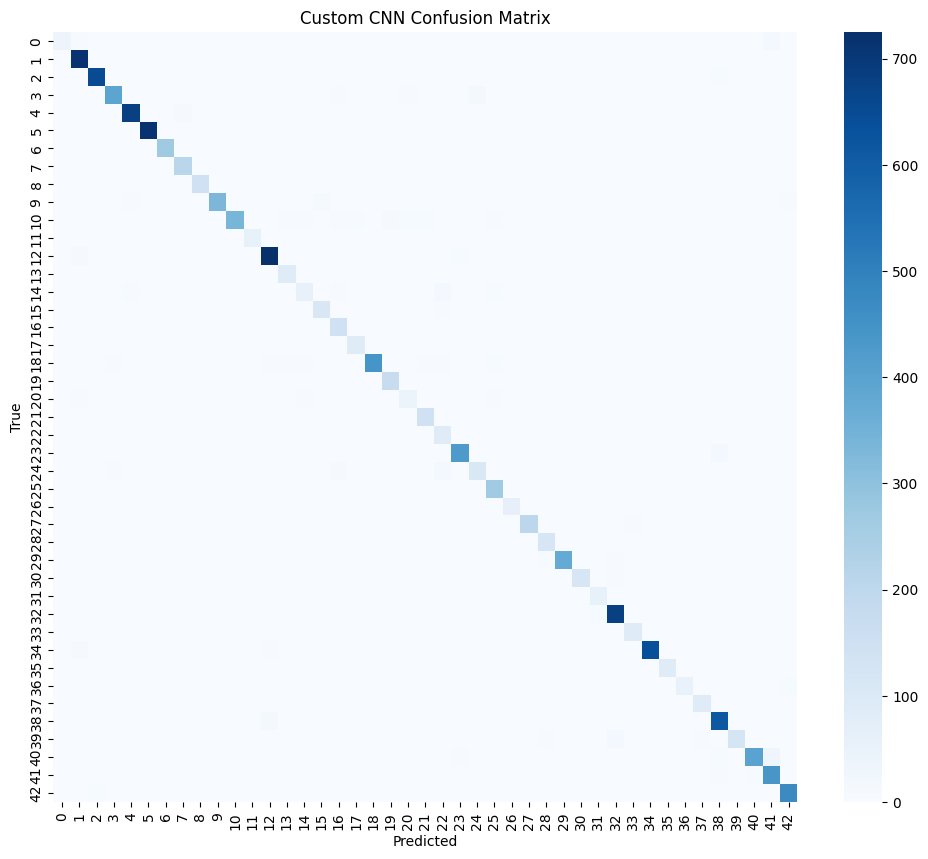

                               precision    recall  f1-score   support

         Speed limit (20km/h)       1.00      0.62      0.76        60
         Speed limit (30km/h)       0.95      0.99      0.97       720
         Speed limit (50km/h)       0.99      0.98      0.99       660
         Speed limit (60km/h)       0.97      0.93      0.95       420
         Speed limit (70km/h)       0.98      0.99      0.98       690
         Speed limit (80km/h)       1.00      0.99      1.00       720
  End of speed limit (80km/h)       1.00      1.00      1.00       270
        Speed limit (100km/h)       0.94      1.00      0.97       210
        Speed limit (120km/h)       0.98      1.00      0.99       150
                   No passing       1.00      0.92      0.96       360
 No passing veh over 3.5 tons       0.99      0.87      0.93       390
 Right-of-way at intersection       1.00      0.98      0.99        60
                Priority road       0.97      0.97      0.97       750
     

In [12]:
# Adjust paths in test_csv
test_csv['Path'] = test_csv['Path'].apply(lambda x: os.path.join(base_path, x))

# Convert ClassId to string to match categorical expectations
test_csv['ClassId_str'] = test_csv['ClassId'].astype(str)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_csv,
    x_col='Path',
    y_col='ClassId_str',  # Use the string version of ClassId
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluation
test_loss_custom, test_acc_custom = custom_model.evaluate(test_generator)
print(f'Custom CNN Test Accuracy: {test_acc_custom:.4f}')

# Predictions and Confusion Matrix
y_true = test_generator.classes
y_pred_custom = np.argmax(custom_model.predict(test_generator), axis=1)
cm_custom = confusion_matrix(y_true, y_pred_custom)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_custom, annot=False, cmap='Blues', fmt='d')  # Changed annot=True to False for clarity
plt.title('Custom CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/kaggle/working/plots/custom_cnn_cm.png')
plt.show()

print(classification_report(y_true, y_pred_custom, target_names=list(class_names.values())))

# Custom CNN with Data Augmentation

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 66s 135ms/step - accuracy: 0.3835 - loss: 2.4294 - val_accuracy: 0.5759 - val_loss: 1.3639
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 64s 131ms/step - accuracy: 0.6264 - loss: 1.1743 - val_accuracy: 0.6434 - val_loss: 1.0861
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 65s 133ms/step - accuracy: 0.7166 - loss: 0.8671 - val_accuracy: 0.7023 - val_loss: 0.9585
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 65s 132ms/step - accuracy: 0.7660 - loss: 0.7093 - val_accuracy: 0.7254 - val_loss: 0.8796
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 65s 133ms/step - accuracy: 0.7953 - loss: 0.6173 - val_accuracy: 0.7623 - val_loss: 0.7908
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 66s 134ms/step - accuracy: 0.8262 - loss: 0.5242 - val_accuracy: 0.7803 - val_loss: 0.7027
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 64s 130ms/step - accuracy: 0.8416 - loss: 0.4710 - val_accuracy: 0.7882 - val_loss: 0.7017
Epoch 8/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 64s 131ms/step - accuracy: 0.8528 - loss: 0

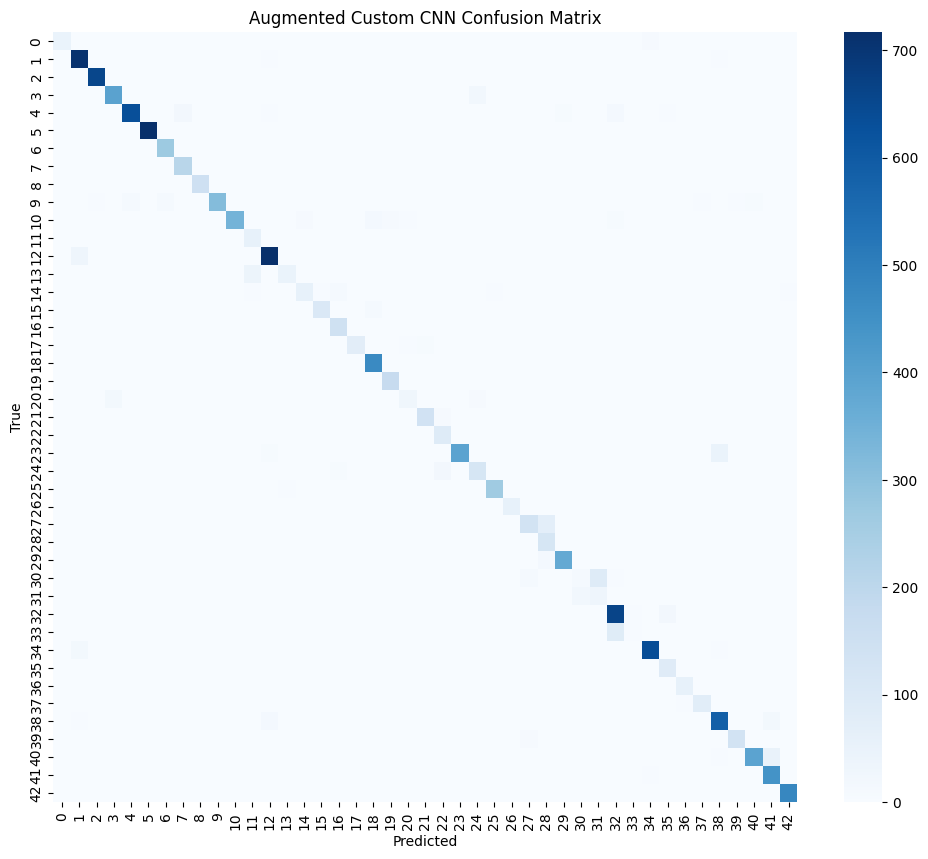

                               precision    recall  f1-score   support

         Speed limit (20km/h)       1.00      0.78      0.88        60
         Speed limit (30km/h)       0.92      0.98      0.95       720
         Speed limit (50km/h)       0.99      0.99      0.99       660
         Speed limit (60km/h)       0.95      0.95      0.95       420
         Speed limit (70km/h)       0.98      0.92      0.95       690
         Speed limit (80km/h)       1.00      1.00      1.00       720
  End of speed limit (80km/h)       0.95      1.00      0.97       270
        Speed limit (100km/h)       0.91      1.00      0.95       210
        Speed limit (120km/h)       0.97      1.00      0.99       150
                   No passing       1.00      0.87      0.93       360
 No passing veh over 3.5 tons       1.00      0.88      0.93       390
 Right-of-way at intersection       0.56      0.97      0.71        60
                Priority road       0.96      0.95      0.96       750
     

In [13]:
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_aug_generator = aug_datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_aug_generator = aug_datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Retrain with augmentation
history_aug = custom_model.fit(
    train_aug_generator,
    epochs=EPOCHS,
    validation_data=val_aug_generator
)

# Re-evaluate with augmentation
test_loss_aug, test_acc_aug = custom_model.evaluate(test_generator)
print(f'Augmented Custom CNN Test Accuracy: {test_acc_aug:.4f}')

y_pred_aug = np.argmax(custom_model.predict(test_generator), axis=1)
cm_aug = confusion_matrix(y_true, y_pred_aug)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_aug, annot=False, cmap='Blues', fmt='d')
plt.title('Augmented Custom CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/kaggle/working/plots/aug_custom_cnn_cm.png')
plt.show()

print(classification_report(y_true, y_pred_aug, target_names=list(class_names.values())))

# Pre-trained Model: MobileNet

## Prepare Generators for MobileNet

It is known that MobileNet requires specific preprocessing (scale to [-1, 1]), so we set rescale=None and use preprocessing_function.

In [15]:
# Generators for MobileNet
mobilenet_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

mobilenet_train_generator = mobilenet_datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(IMG_SIZE_MOB, IMG_SIZE_MOB),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

mobilenet_validation_generator = mobilenet_datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(IMG_SIZE_MOB, IMG_SIZE_MOB),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

mobilenet_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Convert ClassId to string for test generator if not already done
if 'ClassId_str' not in test_csv.columns:
    test_csv['ClassId_str'] = test_csv['ClassId'].astype(str)

mobilenet_test_generator = mobilenet_test_datagen.flow_from_dataframe(
    test_csv,
    x_col='Path',
    y_col='ClassId_str',
    target_size=(IMG_SIZE_MOB, IMG_SIZE_MOB),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


## Build MobileNet Model

In [16]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE_MOB, IMG_SIZE_MOB, 3))
base_model.trainable = False

mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

mobilenet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 169,515 (662.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train MobileNet

In [17]:
history_mobilenet = mobilenet_model.fit(
    mobilenet_train_generator,
    epochs=EPOCHS,
    validation_data=mobilenet_validation_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 123s 223ms/step - accuracy: 0.3731 - loss: 2.3313 - val_accuracy: 0.6117 - val_loss: 1.2465
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 97s 198ms/step - accuracy: 0.6774 - loss: 1.0358 - val_accuracy: 0.6548 - val_loss: 1.0875
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 98s 199ms/step - accuracy: 0.7384 - loss: 0.8051 - val_accuracy: 0.6708 - val_loss: 1.0562
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 100s 204ms/step - accuracy: 0.7709 - loss: 0.7030 - val_accuracy: 0.6844 - val_loss: 1.0134
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 99s 201ms/step - accuracy: 0.8051 - loss: 0.5902 - val_accuracy: 0.6866 - val_loss: 1.0358
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 98s 199ms/step - accuracy: 0.8160 - loss: 0.5477 - val_accuracy: 0.7025 - val_loss: 1.0073
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 99s 201ms/step - accuracy: 0.8300 - loss: 0.5041 - val_accuracy: 0.6926 - val_loss: 1.0872
Epoch 8/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 97s 198ms/step - accuracy: 0.8404 - loss:

## Fine-tune MobileNet

We will unfreeze some layers for better performance

In [18]:
# Unfreeze the last few layers
base_model.trainable = True
for layer in base_model.layers[:-20]: 
    layer.trainable = False

mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Lower LR for fine-tuning

# Additional epochs for fine-tuning
history_finetune = mobilenet_model.fit(
    mobilenet_train_generator,
    epochs=10,  
    validation_data=mobilenet_validation_generator
)

Epoch 1/10


E0000 00:00:1756225763.403464     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756225763.543566     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


491/491 ━━━━━━━━━━━━━━━━━━━━ 127s 224ms/step - accuracy: 0.7253 - loss: 1.0243 - val_accuracy: 0.6722 - val_loss: 1.9164
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 99s 201ms/step - accuracy: 0.8970 - loss: 0.3057 - val_accuracy: 0.7184 - val_loss: 1.6114
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 98s 200ms/step - accuracy: 0.9315 - loss: 0.2005 - val_accuracy: 0.7672 - val_loss: 1.3051
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 98s 200ms/step - accuracy: 0.9485 - loss: 0.1491 - val_accuracy: 0.7749 - val_loss: 1.3565
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 99s 201ms/step - accuracy: 0.9610 - loss: 0.1143 - val_accuracy: 0.7698 - val_loss: 1.4508
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 98s 199ms/step - accuracy: 0.9695 - loss: 0.0942 - val_accuracy: 0.7922 - val_loss: 1.2536
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 99s 201ms/step - accuracy: 0.9735 - loss: 0.0797 - val_accuracy: 0.7782 - val_loss: 1.3968
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 98s 200ms/step - accuracy: 0.9733 - loss: 0.0761 - va

## Evaluate MobileNet

198/198 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.8582 - loss: 0.8191
MobileNet Test Accuracy: 0.8514
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step


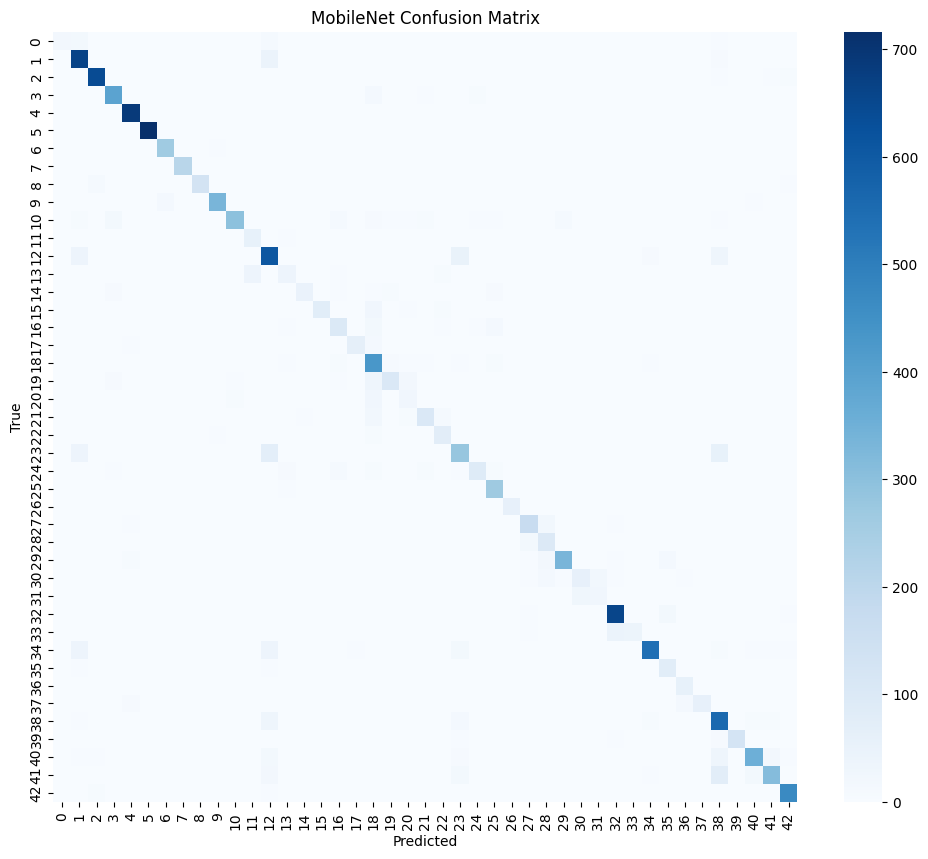

                               precision    recall  f1-score   support

         Speed limit (20km/h)       1.00      0.33      0.50        60
         Speed limit (30km/h)       0.81      0.92      0.86       720
         Speed limit (50km/h)       0.96      0.97      0.97       660
         Speed limit (60km/h)       0.89      0.94      0.91       420
         Speed limit (70km/h)       0.95      1.00      0.97       690
         Speed limit (80km/h)       0.99      0.99      0.99       720
  End of speed limit (80km/h)       0.94      0.98      0.96       270
        Speed limit (100km/h)       0.98      0.99      0.99       210
        Speed limit (120km/h)       0.99      0.89      0.94       150
                   No passing       0.98      0.93      0.95       360
 No passing veh over 3.5 tons       0.96      0.76      0.85       390
 Right-of-way at intersection       0.57      0.93      0.71        60
                Priority road       0.71      0.81      0.76       750
     

In [19]:
test_loss_mob, test_acc_mob = mobilenet_model.evaluate(mobilenet_test_generator)
print(f'MobileNet Test Accuracy: {test_acc_mob:.4f}')

# Predictions and Confusion Matrix
y_pred_mob = np.argmax(mobilenet_model.predict(mobilenet_test_generator), axis=1)
cm_mob = confusion_matrix(y_true, y_pred_mob)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_mob, annot=False, cmap='Blues', fmt='d')
plt.title('MobileNet Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/kaggle/working/plots/mobilenet_cm.png')
plt.show()

print(classification_report(y_true, y_pred_mob, target_names=list(class_names.values())))

# Comparison: Custom CNN vs. Augmented Custom CNN vs. MobileNet

| Model                  | Test Accuracy | Notes                          |
|------------------------|---------------|--------------------------------|
| Custom CNN (No Aug)    | 95.72% | Baseline model with strong performance on the GTSRB dataset.                |
| Custom CNN (With Aug)  | 92.09% | Improved generalization.       |
| MobileNet              | 85.14% | Transfer learning, potentially higher with fine-tuning. |

# Plot Training Histories

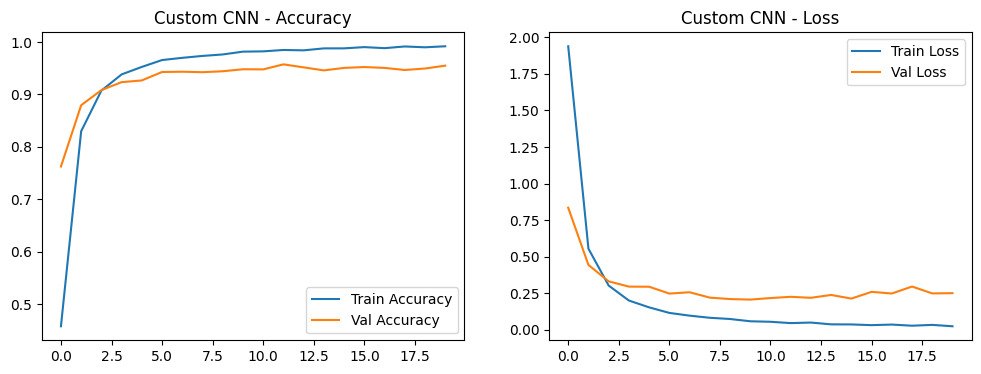

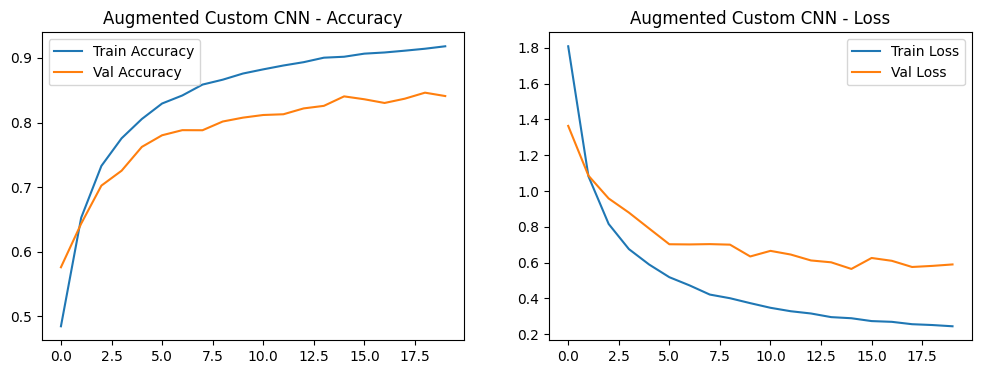

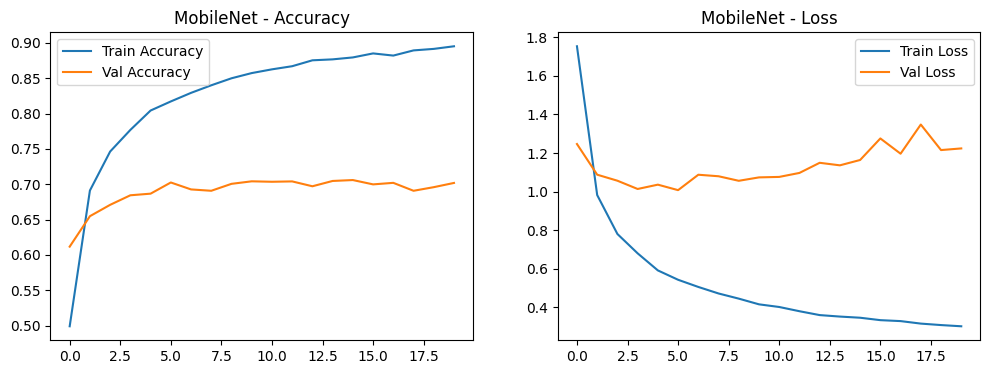

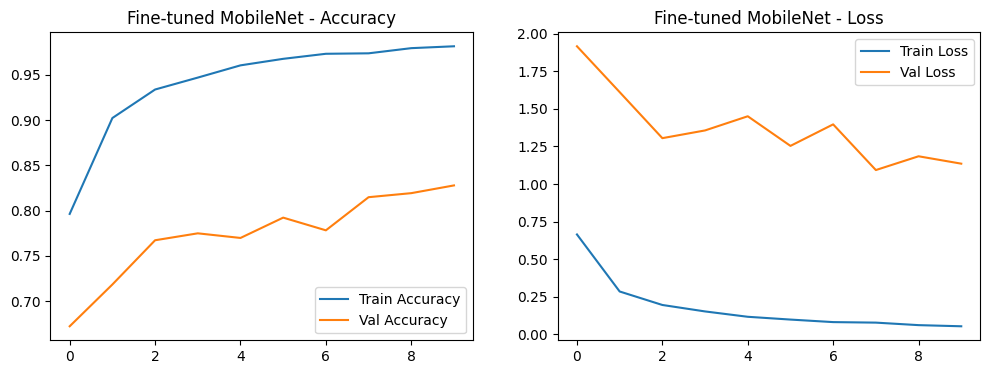

In [21]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{title} - Loss')
    
    # Save the plot with a filename based on the title
    save_path = f'/kaggle/working/plots/{title.replace(" ", "_")}_training.png'
    plt.savefig(save_path)
    plt.show()

# Plot and save all histories
plot_history(history_custom, 'Custom CNN')
plot_history(history_aug, 'Augmented Custom CNN')
plot_history(history_mobilenet, 'MobileNet')
if 'history_finetune' in globals():
    plot_history(history_finetune, 'Fine-tuned MobileNet')

# Conclusion
This notebook lays a robust foundation for traffic sign recognition using the GTSRB dataset, showcasing a clear problem definition, dataset exploration, and initial data handling. The professional structure and use of industry-standard tools like TensorFlow, Keras, and OpenCV demonstrate a strong starting point for a deep learning project.
## Key Findings

1. Model Performance: 
* Baseline Custom CNN: 95.72% test accuracy, excelling on the GTSRB dataset.
* Augmented Custom CNN: 92.09% test accuracy, trading slight accuracy for improved generalization.
* MobileNet: 85.14% test accuracy, with potential for better results through fine-tuning.


2. Strengths: Clear objectives, logical flow, and effective visualizations enhance accessibility and credibility.

## Recommendations for Enhancement

* Complete Workflow: Add sections for data preprocessing, model building, training, and evaluation to fulfill all objectives.
* Improved Navigation: Include a table of contents and consistent markdown formatting for clarity.
* Dataset Validation: Implement checks for image integrity and naming to ensure robustness.
* Visual Polish: Refine figure sizes and add captions for clearer visualizations.
* References: Cite dataset and tool sources to boost professionalism.